<a href="https://colab.research.google.com/github/thxsxth/RLMimic/blob/master/Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
cd 'drive/My Drive/sepsis3-cohort'

[Errno 2] No such file or directory: 'drive/My Drive/sepsis3-cohort'
/content/drive/My Drive/sepsis3-cohort


In [3]:
import torch
import numpy as np
import pandas as pd
import datetime as dt
import random
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import os
import glob
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence,pad_packed_sequence
import torch.nn.init as weight_init
import scipy

In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'

### Load the data and process (Should take some time)

In [5]:
from load_and_process import *

In [6]:
from autoencoder_models import state_space_new
from plots import plot_cv_paramters,plot_cv_state,plot_outputs

In [7]:
model=state_space_new(z_dim=5,obs_dim=4,full_dim=12,h_dim=64,a_dim=2,constants_dim=3)
model.load_state_dict(torch.load('./Auto Encoder dicts/deterministic_final.pt'))

<All keys matched successfully>

Helper Function to get patient outputs, from ICU ID

In [ ]:
def pat_outputs(pat_id):
  assert pat_id in co.index

  pat_dataset=modeling_dataset([pat_id],T_max=np.inf)
  pat_loader=DataLoader(pat_dataset,batch_size=len(pat_dataset),shuffle=False,collate_fn=collate_model)

  model.eval()
  with torch.no_grad():
     for batch_num,(trajectories,treatments,constants,mask,seq_lens,obs,others) in enumerate(pat_loader):
        if min(seq_lens)<5:
          return None

        outputs,cvs=model(trajectories,treatments,constants,mask,seq_lens,obs)
  
  return outputs,cvs,obs,seq_lens,constants



In [ ]:
outputs,cvs,_,_,_=pat_outputs(pat)

Let's save all the CV States of our cohort for future analysis

In [8]:
patient_list=list(np.load('new_pats.npy'))
pats2=list(np.load('pat_ids_with_cv.npy'))

In [10]:
dead_pats=co[co.death_time.notna()].index

# dead_pats=co[co.icu_los<5].index


### These patients have both died in the ICU and have more than 5 time points

In [11]:
dead_pats=list(set(dead_pats).intersection(set(pats2)))
temp=set(co[co.outtime>co.death_time].index)
dead_pats2=list(temp.intersection(dead_pats))

In [12]:
len(dead_pats2)

1824

In [13]:
data_set=modeling_dataset(dead_pats2,T_max=50000)
loader=DataLoader(data_set,batch_size=1,collate_fn=collate_model,shuffle=False)


In [ ]:
time_to_deaths=[]
cvs_=[]
pats=[]
with torch.no_grad():
  for i,(trajectories,treatments,constants,mask,seq_lens,obs,others) in enumerate(loader):
      print(i/len(data_set)*100, '% Done')
      if min(seq_lens)<5:
          continue
      outputs,cvs=model(trajectories,treatments,constants,mask,seq_lens,obs)
      pats.append(patient_list[i])
      cvs_.append(cvs.squeeze(0).view(-1,5).numpy()) #T*5
      time_to_deaths.append(np.arange(seq_lens[0],0,step=-1))

### Recall CV_s are 5d HR,R,C,T,SV

In [61]:
pat_cvs=np.concatenate(cvs_,axis=0) #(B*T)*5
times=np.concatenate(time_to_deaths,axis=0)

In [43]:
pat_cvs.shape,times.shape

((405441, 5), (405441,))

In [62]:
RC=pat_cvs[:,1]*pat_cvs[:,2]

In [63]:
SV_C=pat_cvs[:,4]/pat_cvs[:,2]
CO_R=pat_cvs[:,1]*pat_cvs[:,4]*pat_cvs[:,0]

In [23]:
import matplotlib.pyplot as plt
import matplotlib
# plt.figure(figsize=(100,100))
# # color_map=matplotlib.colors.Colormap(times)
# plt.scatter(RC,SV_C,c=times,alpha=0.7,cmap=plt.get_cmap("jet"))

In [64]:
dead_pat_df=pd.DataFrame(pat_cvs,columns=['HR','R','C','T','SV'])

In [65]:
dead_pat_df['Time_to_Death']=times

In [68]:
dead_pat_df['RC']=RC
dead_pat_df['SV/C']=SV_C
dead_pat_df['COR']=CO_R

In [69]:
dead_pat_df

,HR,R,C,T,SV,Time_to_Death,RC,SV/C,COR
0,67.439896,1.044650,0.714259,0.815168,70.495750,132,0.746150,98.697784,4966.501465
1,94.860023,1.141438,0.529299,0.570176,68.128395,131,0.604163,128.714264,7376.727539
2,94.408928,1.030797,0.571101,0.582853,68.125374,130,0.588689,119.287796,6629.716797
3,66.536583,0.327550,1.550508,0.604754,69.927269,129,0.507869,45.099583,1524.000610
4,74.637421,0.953894,1.286057,0.776244,69.720451,128,1.226763,54.212547,4963.833008
...,...,...,...,...,...,...,...,...,...
405436,153.437515,0.398188,3.186084,0.386554,61.538509,5,1.268661,19.314777,3759.816650
405437,132.112549,0.385642,3.656864,0.438764,63.491829,4,1.410242,17.362371,3234.794922
405438,147.934921,0.429589,2.398531,0.394838,62.343826,3,1.030383,25.992502,3962.025635
405439,152.858948,0.426798,3.412300,0.390207,61.525906,2,1.456362,18.030626,4013.941650


In [70]:
dead_pat_df["times_cat"] = pd.cut(dead_pat_df['Time_to_Death'],
                               bins=[0.0, 3.0, 5.0, 10.0, 24.0, 48.0, np.inf],
                               labels=[1, 2, 3, 4, 5,6])

In [71]:
# dead_pat_df.to_csv('dead_cvs.csv')

In [72]:
np.mean(dead_pat_df['COR'])

4480.22509765625

In [78]:
dead_pat_df["COR_scaled"]=(dead_pat_df['COR']-np.mean(dead_pat_df['COR']))/np.std(dead_pat_df['COR'])

In [87]:
dead_df2=dead_pat_df[dead_pat_df.times_cat<5]

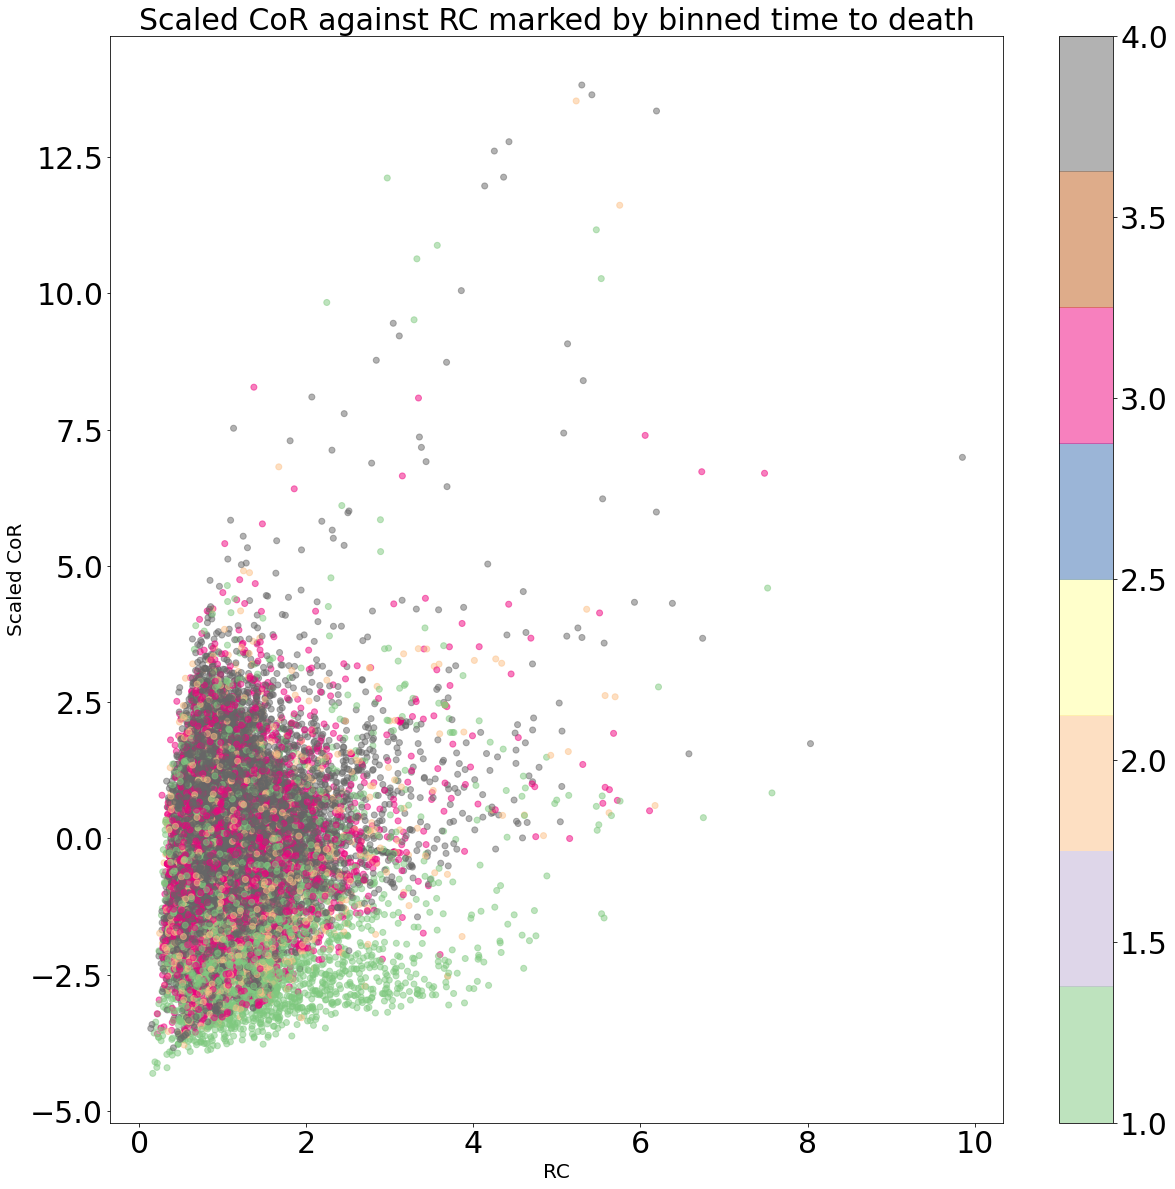

In [108]:
plt.figure(figsize=(20,20))
sc=plt.scatter(dead_df2['RC'],dead_df2['COR_scaled'],
    c=dead_df2["times_cat"], cmap=plt.get_cmap("Accent"),alpha=0.5
)
plt.colorbar(sc)
plt.xlabel('RC',fontdict={'fontsize':20})
plt.ylabel('Scaled CoR',fontdict={'fontsize':20})
plt.title('Scaled CoR against RC marked by binned time to death',fontdict={'fontsize':30})
# plt.show()
plt.savefig('CV_scatter3.jpg')

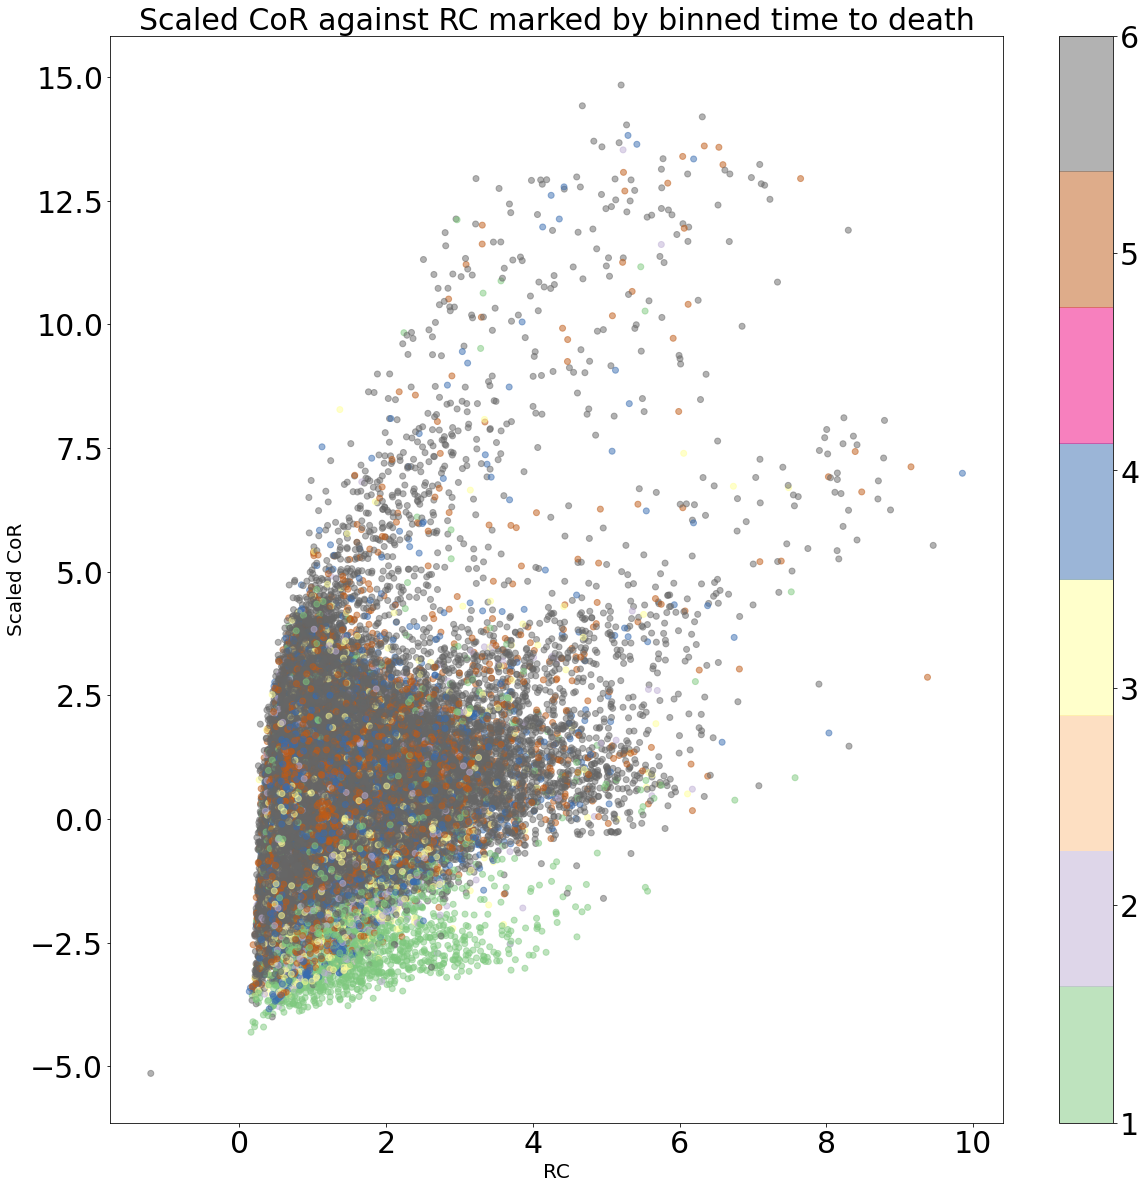

In [109]:
plt.figure(figsize=(20,20))
sc=plt.scatter(dead_pat_df['RC'],dead_pat_df['COR_scaled'],
    c=dead_pat_df["times_cat"], cmap=plt.get_cmap("Accent"),alpha=0.5
)
plt.colorbar(sc)
plt.xlabel('RC',fontdict={'fontsize':20})
plt.ylabel('Scaled CoR',fontdict={'fontsize':20})
plt.title('Scaled CoR against RC marked by binned time to death',fontdict={'fontsize':30})
# plt.show()
plt.savefig('CV_scatter_.jpg')

#### We will try to discriminate last 12 hours of dead patients vs the Rest

In [224]:
dead_pat_df['death_12']=dead_pat_df.Time_to_Death<12

In [225]:
dead_pat_df['death_12']=dead_pat_df['death_5'].astype('int')

Let's only consider the last 48 hours

In [ ]:
dead_pat_df_2=dead_pat_df[dead_pat_df['Time_to_Death']<48]

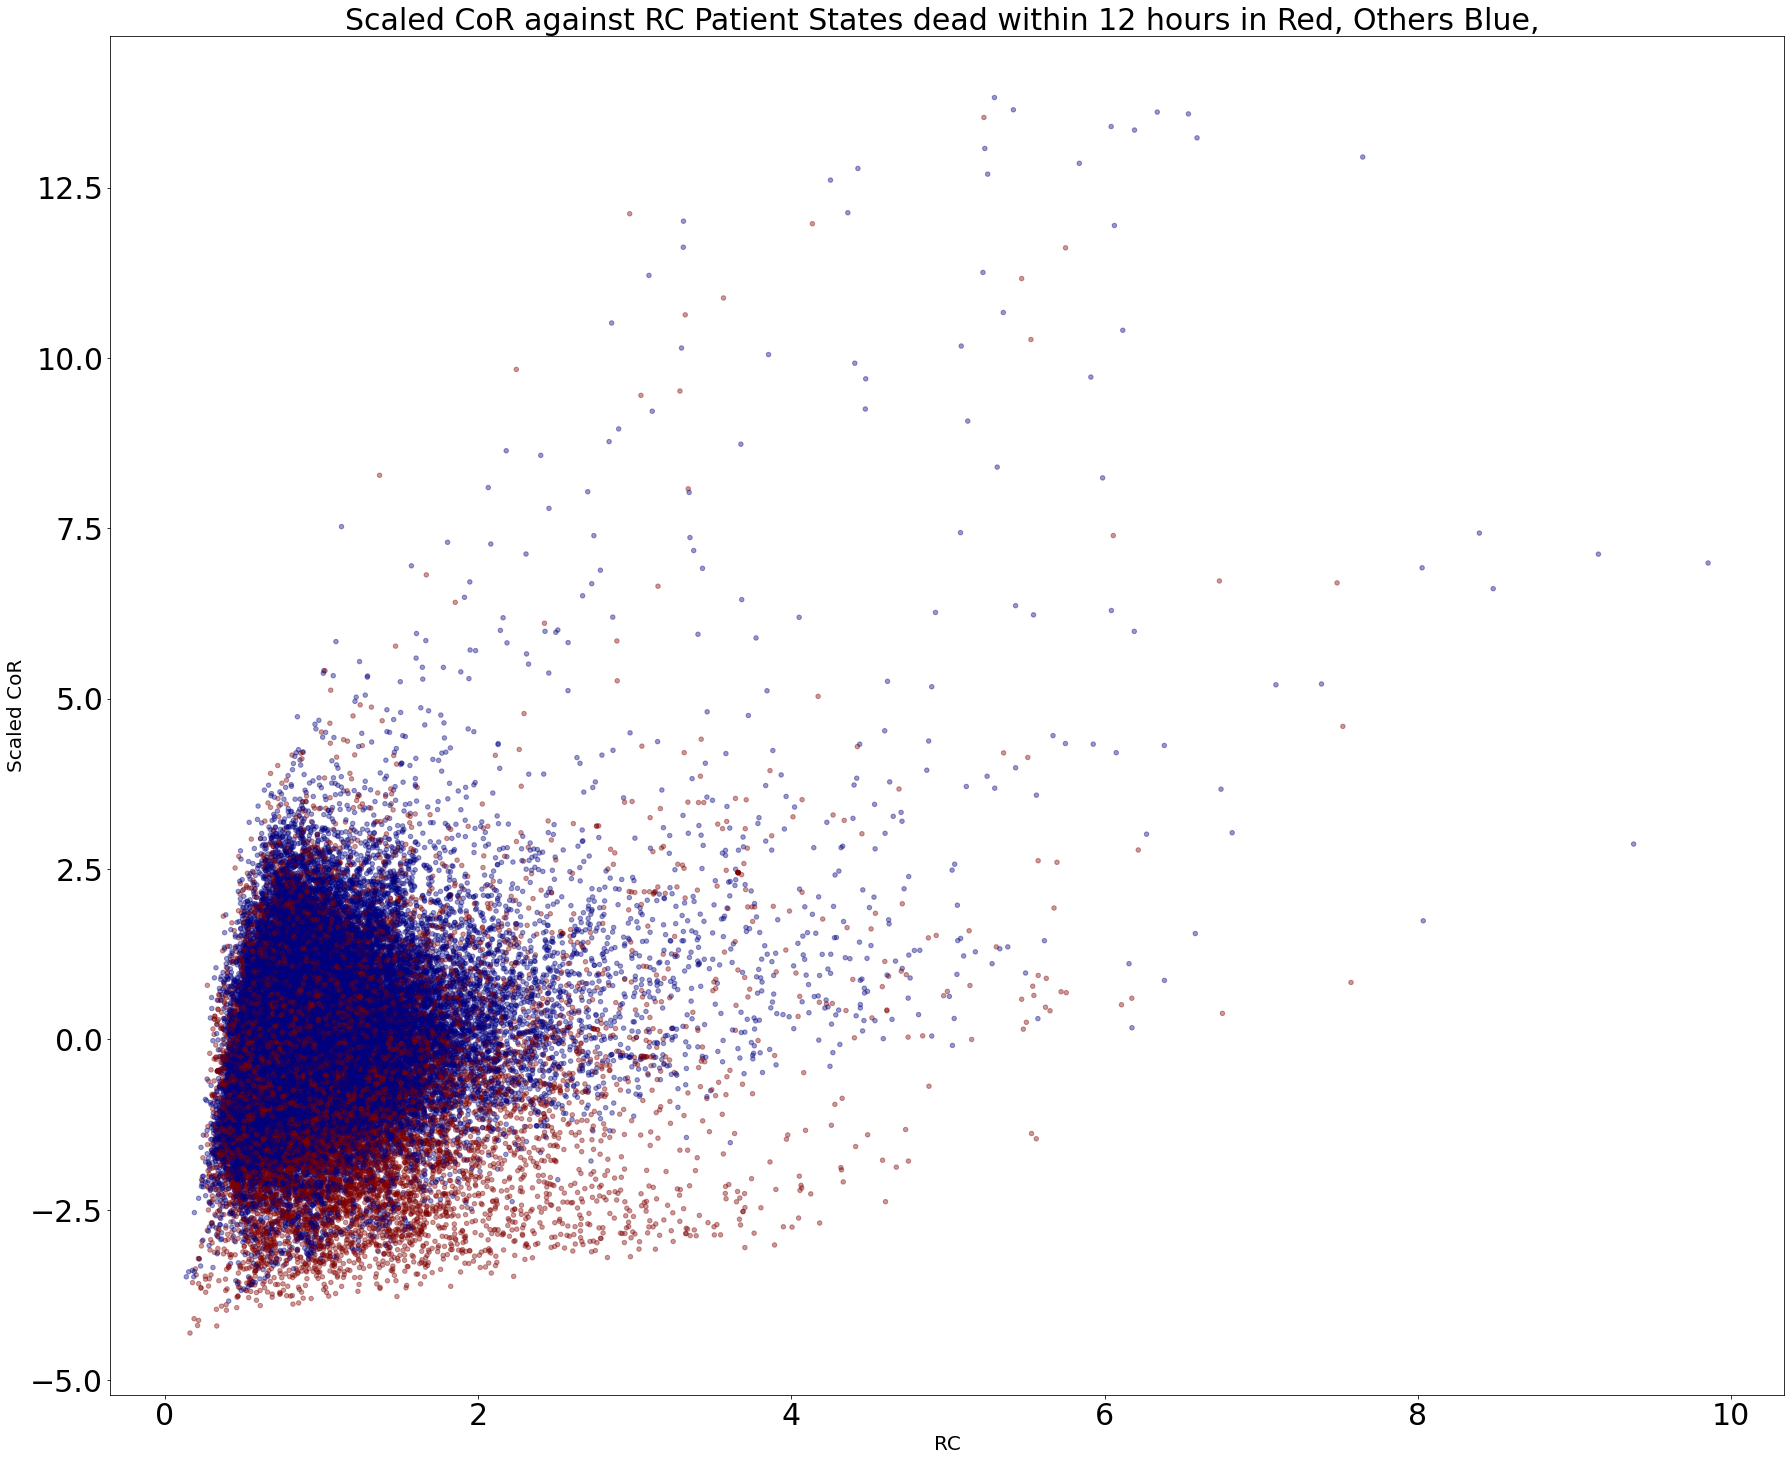

In [130]:
dead_pat_df_2.plot(kind="scatter", x="RC", y="COR_scaled", alpha=0.4,
    figsize=(30,25),
    c="death_12", cmap=plt.get_cmap("jet"), colorbar=False,
)

plt.xlabel('RC',fontdict={'fontsize':20})
plt.ylabel('Scaled CoR',fontdict={'fontsize':20})
plt.title('Scaled CoR against RC Patient States dead within 12 hours in Red, Others Blue, ',fontdict={'fontsize':30})
plt.savefig('CV_dead_12.jpg')


### Now let's try to classify using CV states

In [285]:
dead_pat_df['dead_5']=(dead_pat_df['Time_to_Death']<6).astype('int64')
dead_pat_5=dead_pat_df[dead_pat_df['dead_5']==1]

In [237]:
len(dead_pat_5)

9120

In [286]:
# dead_pat_df_24=dead_pat_df[dead_pat_df.Time_to_Death>24]
dead_pat_df_24=dead_pat_df
index=np.random.choice(np.arange(len(dead_pat_5)),len(dead_pat_5))
dead_24=dead_pat_df_24.iloc[index]

In [287]:
temp=pd.concat([dead_24,dead_pat_5],axis=0)

In [288]:
temp.shape

(18240, 12)

### Let's try to classify based on CV States

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [332]:
temp.head()

,HR,R,C,T,SV,Time_to_Death,RC,SV/C,COR,times_cat,COR_scaled,dead_5
4154,76.730591,0.640692,1.320371,0.699026,69.368484,261,0.845952,52.537109,3410.203613,6,-1.118842,0
2043,89.928871,0.817438,0.881632,0.610721,68.393814,490,0.720679,77.576378,5027.716797,6,0.572471,0
6296,58.476196,0.869215,1.169284,0.918828,71.008003,28,1.016359,60.727772,3609.222168,5,-0.910743,0
1798,59.996693,1.354319,0.725285,0.952863,71.261597,735,0.982267,98.253227,5790.336426,6,1.369886,0
7358,87.242126,1.069992,1.043544,0.690337,68.675674,91,1.116583,65.810036,6410.760254,6,2.018617,0


In [333]:
X=temp[['RC','COR','SV/C']]
X1=temp[['RC','COR_scaled']]
Y=temp['dead_5']

In [290]:
X.shape, Y.shape

((18240, 3), (18240,))

### Training and Test Split

In [291]:
X_train, X_test, y_train, y_test = train_test_split(
X, Y, test_size=0.33, random_state=42)

In [334]:
X1_train, X1_test, y1_train, y1_test = train_test_split(
X1, Y, test_size=0.33, random_state=42)

In [343]:
svm=SVC(kernel='poly',degree=1)
lr=LogisticRegression()
rf=RandomForestClassifier(n_estimators=500,max_depth=20,random_state=42)
tree_clf=DecisionTreeClassifier(max_depth=10)


In [344]:
rf.fit(X1_train,y1_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [345]:
rf.score(X1_test,y1_test)

0.7312292358803987

In [346]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [347]:
rf.score(X_train,y_train),rf.score(X_test,y_test)

(0.9610474631751228, 0.7895348837209303)

#### For Simplicity Let's consider a 2 levels deep Decision Tree

In [330]:
tree_clf=DecisionTreeClassifier(max_depth=2,random_state=42)
tree_clf.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [331]:
tree_clf.score(X_train,y_train),tree.score(X_test,y_test)

(0.6981996726677577, 0.7403654485049834)

In [312]:
viz

In [ ]:
viz.save("decision_tree.svg")

#### Decision Tree Plotted

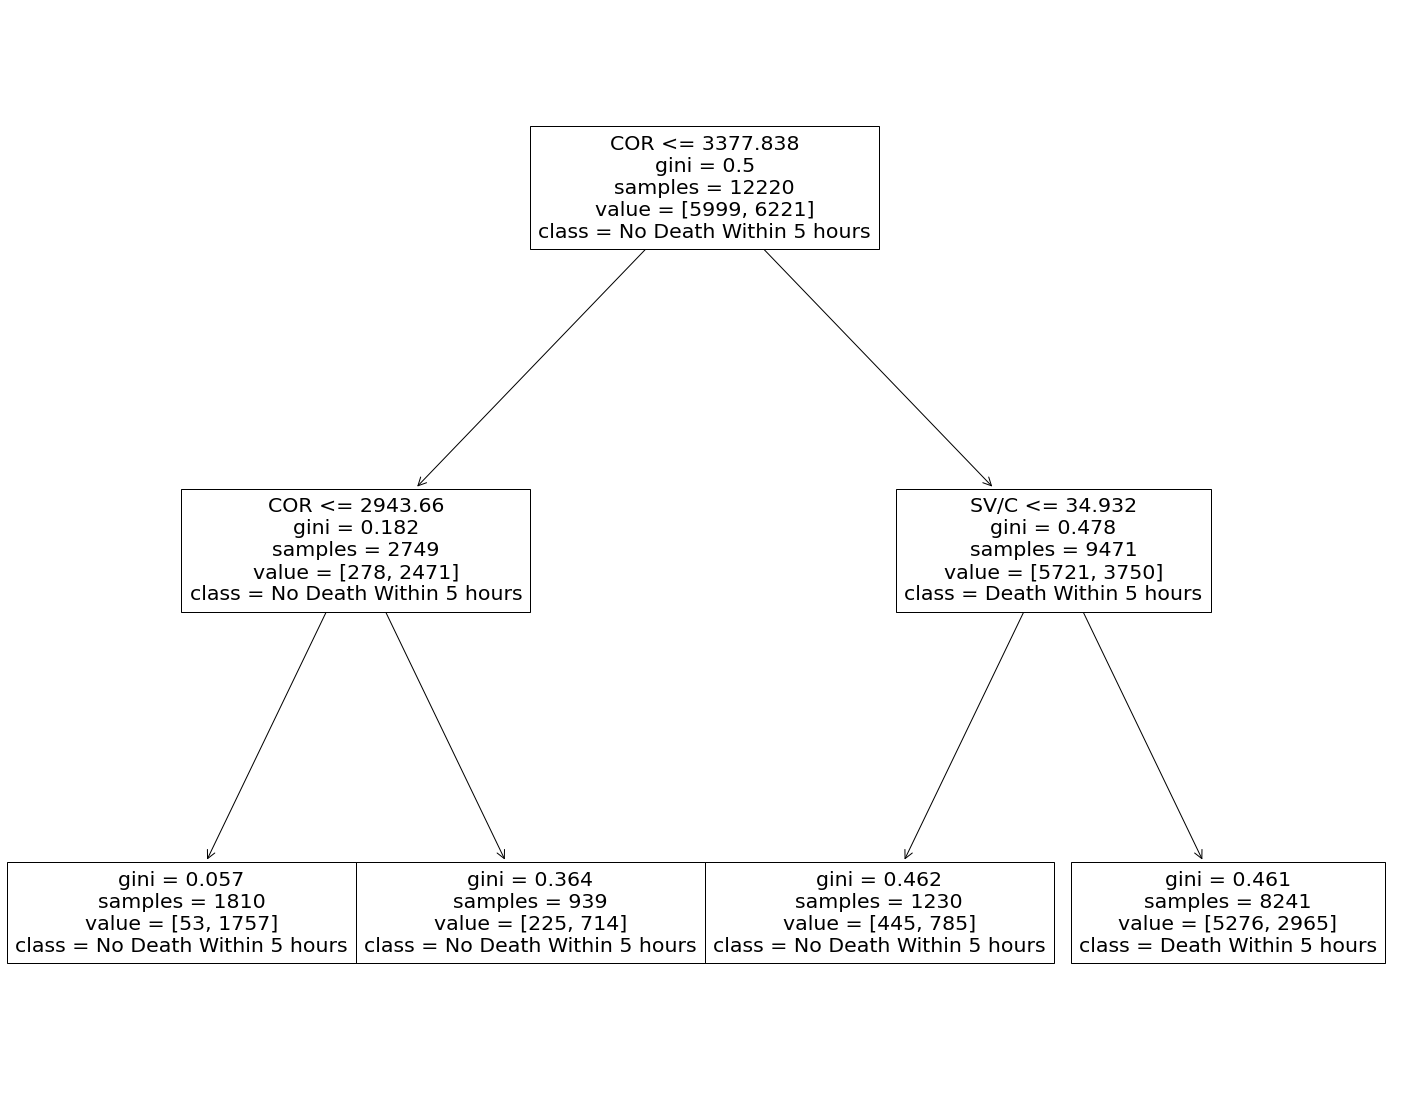

In [328]:
from sklearn.tree import plot_tree
fig=plt.figure(figsize=(25,20))
_=plot_tree(tree_clf,
                feature_names=['RC','COR','SV/C'],  
                                class_names=['Death Within 5 hours', 'No Death Within 5 hours'])

In [337]:
svm=SVC()

In [342]:
lr=LogisticRegression()
lr.fit(X1_train,y1_train)
lr.score(X1_train,y1_train),lr.score(X1_test,y1_test)

(0.6645662847790508, 0.6636212624584718)

In [340]:
svm.fit(X1_train,y1_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [341]:
svm.score(X1_train,y1_train),svm.score(X1_test,y1_test)

(0.692962356792144, 0.6885382059800664)